# 🛒 Rossmann Store Sales Forecasting Project — Business-focused Forecasting (with Explainability)

This notebook is an end-to-end forecasting project for the Rossmann Store Sales dataset, extended with model explainability: SHAP, permutation importance, and Partial Dependence analysis.

In [ ]:
# All project imports - run this cell before loading the dataset so you can pip-install missing packages
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn and helpers
import sklearn
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# LightGBM / XGBoost (optional but recommended)
try:
    import lightgbm as lgb
except Exception:
    lgb = None

try:
    import xgboost as xgb
except Exception:
    xgb = None

# Explainability libraries
try:
    import shap
except Exception:
    shap = None

try:
    from pdpbox import pdp, info_plots
except Exception:
    pdp = None

import joblib
import math
import json

print('Python', sys.version)
print('Pandas', pd.__version__)
print('NumPy', np.__version__)
print('Sklearn', sklearn.__version__)
print('Matplotlib', matplotlib.__version__)

print('Seaborn', sns.__version__)
print('LightGBM', getattr(lgb, '__version__', 'not installed'))
print('XGBoost', getattr(xgb, '__version__', 'not installed'))
print('SHAP', getattr(shap, '__version__', 'not installed') if shap is not None else 'not installed')
print('PDPbox', 'installed' if pdp is not None else 'not installed')

# Create folders
os.makedirs('data', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('outputs', exist_ok=True)


Python 3.10.18 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:08:55) [MSC v.1929 64 bit (AMD64)]
Pandas 2.3.2
NumPy 2.2.6
Sklearn 1.7.2
Matplotlib 3.10.6
Seaborn 0.13.2
LightGBM 4.6.0
XGBoost 3.0.5
SHAP 0.48.0
PDPbox installed


## 1. Project Introduction & Business Understanding

Brief: Forecast daily store sales to support inventory, staffing, and promotions. Explainability is added to increase trust with stakeholders.

## 2. Dataset Loading

Place `train.csv`, `test.csv`, `store.csv` in the `./data/` directory before running the following cell.

In [41]:
DATA_DIR = Path('data')
TRAIN_PATH = DATA_DIR / 'train.csv'
TEST_PATH = DATA_DIR / 'test.csv'
STORE_PATH = DATA_DIR / 'store.csv'

for p in [TRAIN_PATH, TEST_PATH, STORE_PATH]:
    print(p.name, 'exists?', p.exists())

# Load datasets
train = pd.read_csv(TRAIN_PATH, parse_dates=['Date']) if TRAIN_PATH.exists() else pd.DataFrame()
test = pd.read_csv(TEST_PATH, parse_dates=['Date']) if TEST_PATH.exists() else pd.DataFrame()
store = pd.read_csv(STORE_PATH) if STORE_PATH.exists() else pd.DataFrame()

print('\nTrain shape:', train.shape)
print('Test shape:', test.shape)
print('Store shape:', store.shape)


train.csv exists? True
test.csv exists? True
store.csv exists? True

Train shape: (1017209, 9)
Test shape: (41088, 8)
Store shape: (1115, 10)


## 3. Quick EDA (overview plots)

Date range: 2013-01-01 00:00:00 to 2015-07-31 00:00:00
Unique stores: 1115
Zero sales rows: 172871


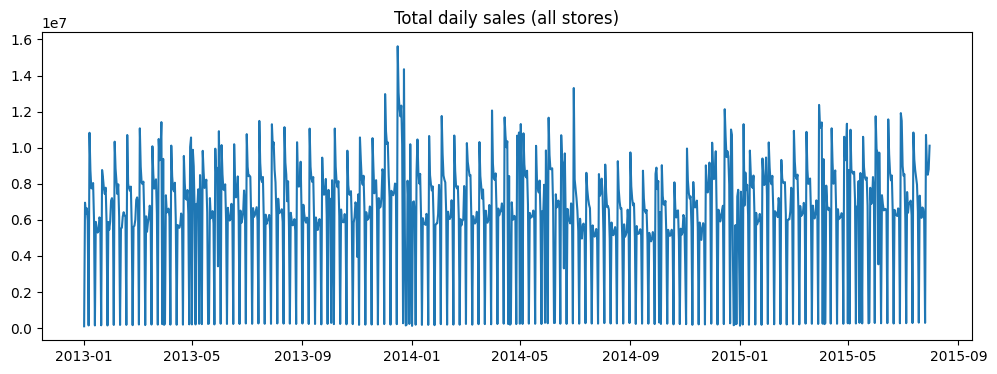

In [42]:
if not train.empty:
    print('Date range:', train['Date'].min(), 'to', train['Date'].max())
    print('Unique stores:', train['Store'].nunique())
    print('Zero sales rows:', (train['Sales']==0).sum())

    daily = train.groupby('Date')['Sales'].sum().reset_index()
    plt.figure(figsize=(12,4))
    plt.plot(daily['Date'], daily['Sales'])
    plt.title('Total daily sales (all stores)')
    plt.show()


## 4. Data Cleaning & Merge store features

In [43]:
if not store.empty and not train.empty:
    train = train.merge(store, how='left', on='Store')
    test = test.merge(store, how='left', on='Store')

for df in [train, test]:
    if 'Open' in df.columns:
        df['Open'] = df['Open'].fillna(1).astype(int)
    if 'StateHoliday' in df.columns:
        df['StateHoliday'] = df['StateHoliday'].fillna('0').astype(str)
    if 'PromoInterval' in df.columns:
        df['PromoInterval'] = df['PromoInterval'].fillna('None')

print('After merge, train shape:', train.shape)


After merge, train shape: (1017209, 18)


## 5. Feature Engineering (calendar, encodings, lags, rolling)

In [44]:
def prepare_calendar_features(df):
    df = df.copy()
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek + 1
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['IsWeekend'] = df['DayOfWeek'].isin([6,7]).astype(int)
    return df

if not train.empty:
    train = prepare_calendar_features(train)
if not test.empty:
    test = prepare_calendar_features(test)

# Ordinal encode StoreType and Assortment
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
for col in ['StoreType','Assortment']:
    if col in train.columns:
        combined = pd.concat([train[[col]], test[[col]]]) if not test.empty else train[[col]]
        encoder.fit(combined.fillna('NA'))
        train[col + '_enc'] = encoder.transform(train[[col]].fillna('NA'))
        if not test.empty:
            test[col + '_enc'] = encoder.transform(test[[col]].fillna('NA'))

def create_lag_features(df, lags=[1,7,14], windows=[7,14]):
    df = df.sort_values(['Store','Date']).copy()
    for lag in lags:
        df[f'Sales_lag_{lag}'] = df.groupby('Store')['Sales'].shift(lag)
    for w in windows:
        df[f'Sales_roll_mean_{w}'] = df.groupby('Store')['Sales'].shift(1).rolling(window=w, min_periods=1).mean().reset_index(level=0, drop=True)
    return df

if 'Sales' in train.columns:
    train = create_lag_features(train)

display(train.head())


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Day,WeekOfYear,IsWeekend,StoreType_enc,Assortment_enc,Sales_lag_1,Sales_lag_7,Sales_lag_14,Sales_roll_mean_7,Sales_roll_mean_14
1016095,1,2,2013-01-01,0,0,0,0,a,1,c,...,1,1,0,2.0,0.0,NaN,NaN,NaN,17755.714286,18217.571429
1014980,1,3,2013-01-02,5530,668,1,0,0,1,c,...,2,1,0,2.0,0.0,0.0,NaN,NaN,5423.714286,5230.071429
1013865,1,4,2013-01-03,4327,578,1,0,0,1,c,...,3,1,0,2.0,0.0,5530.0,NaN,NaN,6553.285714,8392.571429
1012750,1,5,2013-01-04,4486,619,1,0,0,1,c,...,4,1,0,2.0,0.0,4327.0,NaN,NaN,3686.142857,4533.071429
1011635,1,6,2013-01-05,4997,635,1,0,0,1,c,...,5,1,1,2.0,0.0,4486.0,NaN,NaN,3584.285714,3488.071429


## 6. Prepare Modeling Dataset & Baselines

In [45]:
FEATURES = [
    'Store', 'DayOfWeek', 'Month', 'Year', 'Day', 'WeekOfYear', 'IsWeekend',
    'Promo', 'SchoolHoliday'
]

for col in ['StoreType_enc','Assortment_enc','Sales_lag_1','Sales_lag_7','Sales_lag_14','Sales_roll_mean_7','Sales_roll_mean_14']:
    if col in train.columns:
        FEATURES.append(col)

TARGET = 'Sales'

model_df = train.dropna(subset=['Sales_lag_1']) if not train.empty else pd.DataFrame()
print('Model df shape:', model_df.shape)

if not model_df.empty:
    split_date = model_df['Date'].max() - pd.Timedelta(days=42)
    train_mask = model_df['Date'] <= split_date
    val_mask = model_df['Date'] > split_date
    X_train = model_df.loc[train_mask, FEATURES]
    y_train = model_df.loc[train_mask, TARGET]
    X_val = model_df.loc[val_mask, FEATURES]
    y_val = model_df.loc[val_mask, TARGET]
    print('Train rows:', X_train.shape[0], 'Val rows:', X_val.shape[0])

if not model_df.empty:
    baseline_pred = model_df.loc[val_mask, 'Sales_lag_1']


Model df shape: (1016094, 30)
Train rows: 969264 Val rows: 46830


## 7. Evaluation metrics (RMSE, MAE, MAPE, WAPE)

In [46]:
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def wape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

if not model_df.empty:
    print('Baseline metrics:')
    print('RMSE', rmse(y_val, baseline_pred))
    print('MAE', mae(y_val, baseline_pred))
    print('MAPE', mape(y_val, baseline_pred))
    print('WAPE', wape(y_val, baseline_pred))


Baseline metrics:
RMSE 4209.693410298708
MAE 2632.3943198804186
MAPE 30.776093309501434
WAPE 43.85240370065759


In [47]:
# Count missing values per column
missing_counts = X_train.isnull().sum()

# Show only columns that actually have missing values
missing_counts = missing_counts[missing_counts > 0]

print("Missing values per column:")
print(missing_counts)


Missing values per column:
Sales_lag_7      6690
Sales_lag_14    14495
dtype: int64


In [48]:
missing_percent = (X_train.isnull().mean() * 100).round(2)
missing_percent = missing_percent[missing_percent > 0]

print("Percentage of missing values per column:")
print(missing_percent)


Percentage of missing values per column:
Sales_lag_7     0.69
Sales_lag_14    1.50
dtype: float64


In [49]:
print("Total missing values in dataset:", X_train.isnull().sum().sum())


Total missing values in dataset: 21185


In [50]:
# Drop rows with NaNs from training set
train_data = pd.concat([X_train, y_train], axis=1).dropna()
X_train = train_data.drop(columns=["Sales"])
y_train = train_data["Sales"]

# Drop rows with NaNs from validation set
val_data = pd.concat([X_val, y_val], axis=1).dropna()
X_val = val_data.drop(columns=["Sales"])
y_val = val_data["Sales"]

print(f"Train shape after dropping NaNs: {X_train.shape}")
print(f"Validation shape after dropping NaNs: {X_val.shape}")


Train shape after dropping NaNs: (954769, 16)
Validation shape after dropping NaNs: (46829, 16)


## 8. Train Ridge baseline

In [51]:
if not model_df.empty:
    ridge_pipe = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(alpha=1.0))])
    ridge_pipe.fit(X_train, y_train)
    pred_ridge = ridge_pipe.predict(X_val)
    print('Ridge metrics:')
    print('RMSE', rmse(y_val, pred_ridge))
    print('MAE', mae(y_val, pred_ridge))
    print('MAPE', mape(y_val, pred_ridge))
    print('WAPE', wape(y_val, pred_ridge))


Ridge metrics:
RMSE 1170.543424949872
MAE 800.5565676656238
MAPE 12.554005963797366
WAPE 13.336238088938766


In [52]:
import lightgbm as lgb
print(lgb.__version__)


4.6.0


## 9. Train LightGBM (recommended) and evaluate

In [53]:
from lightgbm import early_stopping, log_evaluation

final_model = None
model_name = None

if lgb is not None and not model_df.empty:
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_eval = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'seed': 42
    }

    gbm = lgb.train(
        params,
        lgb_train,
        num_boost_round=1000,
        valid_sets=[lgb_train, lgb_eval],
        callbacks=[
            early_stopping(stopping_rounds=50),
            log_evaluation(period=100)
        ]
    )

    pred_lgb = gbm.predict(X_val, num_iteration=gbm.best_iteration)
    
    print('LightGBM metrics:')
    print('RMSE', rmse(y_val, pred_lgb))
    print('MAE', mae(y_val, pred_lgb))
    print('MAPE', mape(y_val, pred_lgb))
    print('WAPE', wape(y_val, pred_lgb))

    final_model = gbm
    model_name = 'lightgbm'

else:
    print('LightGBM not available or no data. Using Ridge as final model.')
    final_model = ridge_pipe
    model_name = 'ridge'

# ✅ Save the model
os.makedirs('models', exist_ok=True)  # ensure directory exists

if model_name == 'lightgbm':
    final_model.save_model('models/gbm_model.txt')
else:
    joblib.dump(final_model, 'models/final_model.joblib')


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	training's rmse: 1272.64	valid_1's rmse: 1016.46
LightGBM metrics:
RMSE 1016.4558277426437
MAE 627.8513386610915
MAPE 10.274674236034066
WAPE 10.45919211088222


## 10. Explainability: Feature Importance, Permutation Importance, SHAP, PDP
This section runs multiple explainability analyses to help stakeholders understand drivers of predictions.

,feature,importance
4,Day,223
12,Sales_lag_7,194
11,Sales_lag_1,185
5,WeekOfYear,159
13,Sales_lag_14,137
1,DayOfWeek,133
2,Month,103
7,Promo,91
8,SchoolHoliday,33
3,Year,20


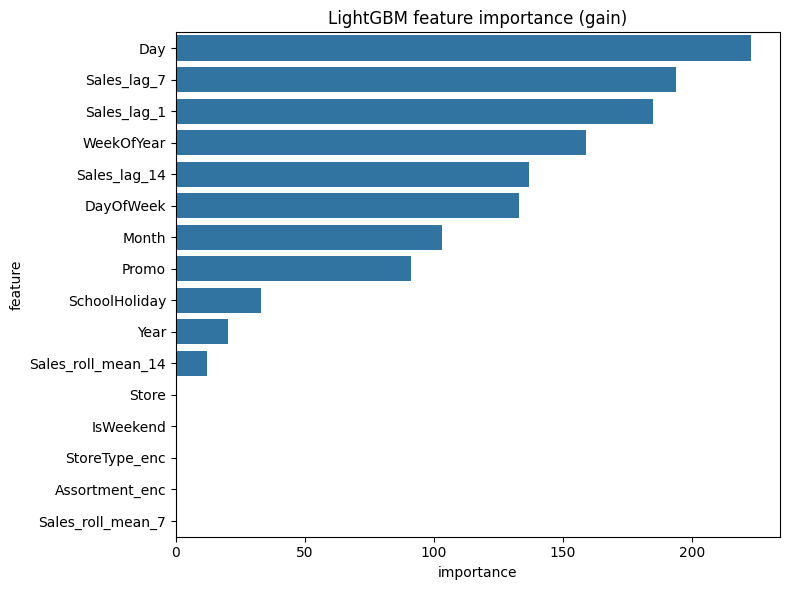

In [54]:
# 10a. Built-in feature importance (for LightGBM)
if model_name == 'lightgbm' and 'gbm' in globals():
    imp = pd.DataFrame({'feature': gbm.feature_name(), 'importance': gbm.feature_importance()}).sort_values('importance', ascending=False)
    display(imp.head(30))
    plt.figure(figsize=(8,6))
    sns.barplot(x='importance', y='feature', data=imp.head(20))
    plt.title('LightGBM feature importance (gain)')
    plt.tight_layout()
    plt.show()


Running permutation importance — this may take some time...


,feature,importance_mean,importance_std
13,Sales_lag_14,0.463273,0.004335
12,Sales_lag_7,0.170413,0.000670
1,DayOfWeek,0.134097,0.000480
7,Promo,0.117892,0.000821
11,Sales_lag_1,0.046786,0.000432
4,Day,0.010047,0.000208
5,WeekOfYear,0.001798,0.000159
2,Month,0.000040,0.000016
6,IsWeekend,0.000000,0.000000
3,Year,0.000000,0.000000


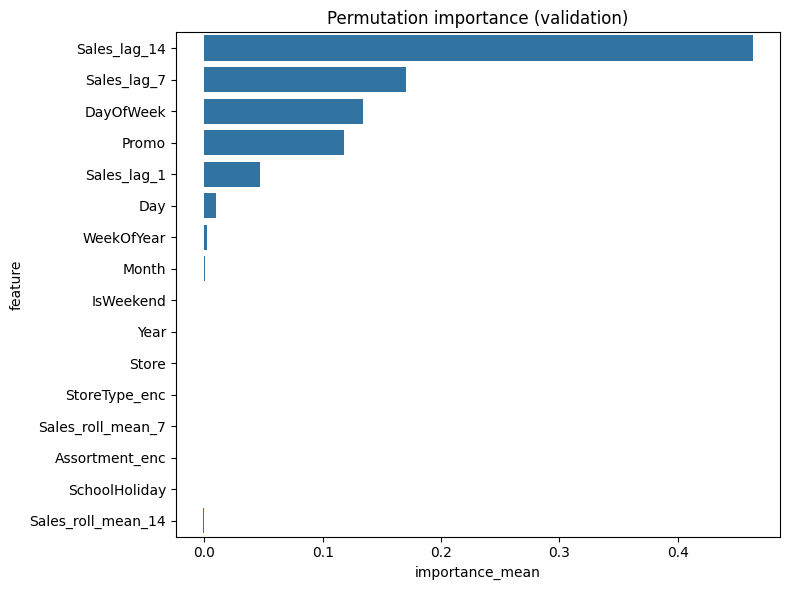

In [55]:
# 10b. Permutation importance (model-agnostic) on validation set
if not model_df.empty:
    try:
        if model_name == 'lightgbm':
            # sklearn's permutation_importance expects an estimator with predict(X). We'll use a wrapper via a lambda.
            from sklearn.base import BaseEstimator, RegressorMixin
            class LGBWrapper(BaseEstimator, RegressorMixin):
                def __init__(self, booster):
                    self.booster = booster
                def fit(self, X, y=None):
                    return self
                def predict(self, X):
                    return self.booster.predict(X, num_iteration=self.booster.best_iteration)
            est = LGBWrapper(gbm) if model_name == 'lightgbm' else final_model
        else:
            est = final_model
        print('Running permutation importance — this may take some time...')
        r = permutation_importance(est, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1)
        perm_imp = pd.DataFrame({'feature': X_val.columns, 'importance_mean': r.importances_mean, 'importance_std': r.importances_std}).sort_values('importance_mean', ascending=False)
        display(perm_imp.head(20))
        plt.figure(figsize=(8,6))
        sns.barplot(x='importance_mean', y='feature', data=perm_imp.head(20))
        plt.title('Permutation importance (validation)')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print('Permutation importance failed:', e)


SHAP summary plot (shows most important features and their effects)


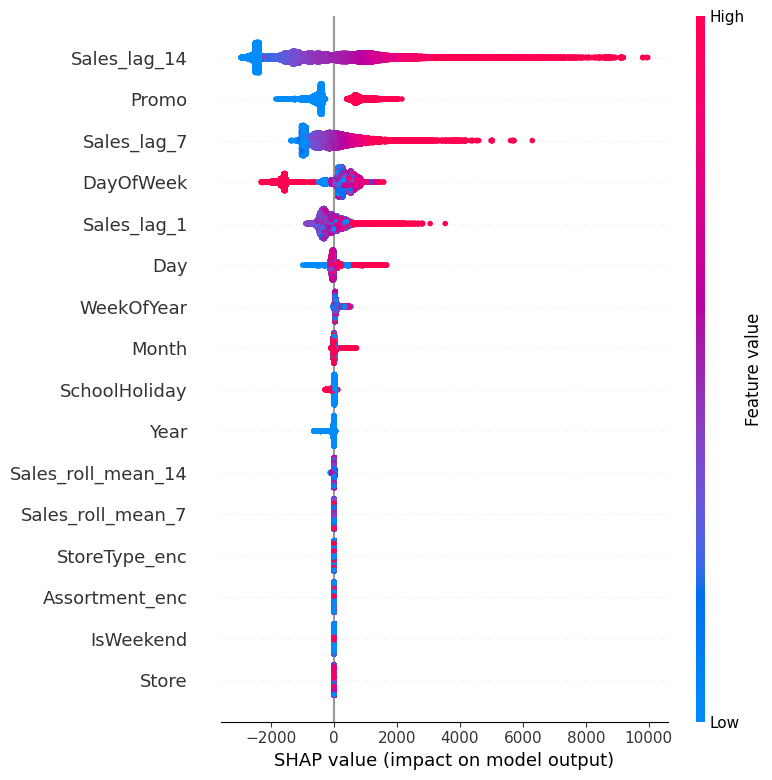

SHAP dependence plot for Day


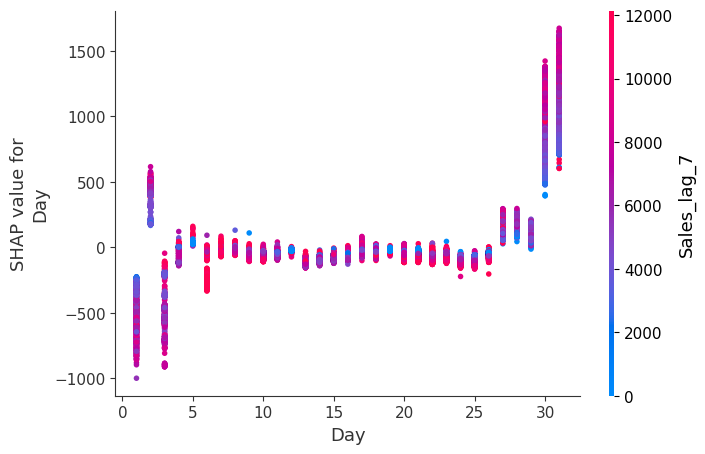

SHAP dependence plot for Sales_lag_7


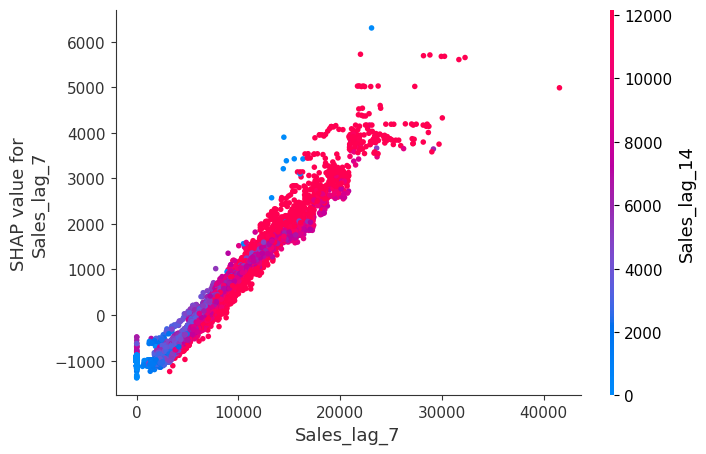

SHAP dependence plot for Sales_lag_1


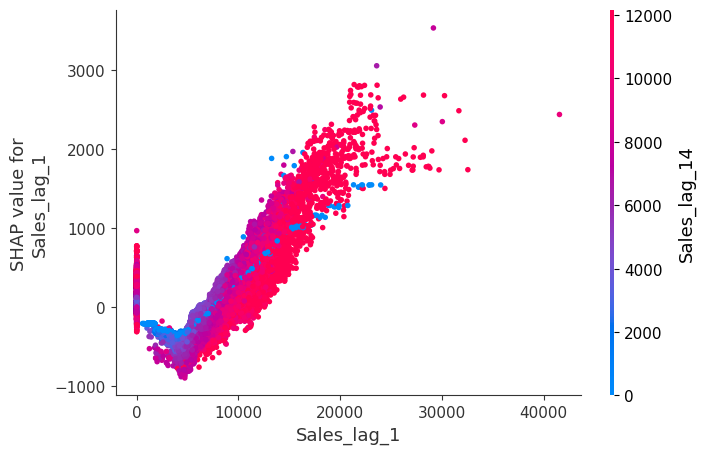

In [56]:
# 10c. SHAP values (global and local explanations) — for tree models use TreeExplainer
if shap is not None and not model_df.empty:
    try:
        if model_name == 'lightgbm':
            explainer = shap.TreeExplainer(gbm)
            shap_values = explainer.shap_values(X_val)
        else:
            explainer = shap.Explainer(final_model.predict, X_train)
            shap_values = explainer(X_val)
        # Summary plot (global)
        print('SHAP summary plot (shows most important features and their effects)')
        shap.summary_plot(shap_values, X_val, show=True)
        # SHAP dependence plot for top features (choose top 3)
        top_features = list(imp['feature'].head(3)) if model_name=='lightgbm' and 'imp' in globals() else list(X_val.columns[:3])
        for feat in top_features:
            print(f'SHAP dependence plot for {feat}')
            shap.dependence_plot(feat, shap_values, X_val, show=True)
    except Exception as e:
        print('SHAP explainability failed:', e)
else:
    print('SHAP is not installed or no model/data available. Install shap to enable SHAP explainability.')


['Store', 'DayOfWeek', 'Month', 'Year', 'Day', 'WeekOfYear', 'IsWeekend', 'Promo', 'SchoolHoliday', 'StoreType_enc', 'Assortment_enc', 'Sales_lag_1', 'Sales_lag_7', 'Sales_lag_14', 'Sales_roll_mean_7', 'Sales_roll_mean_14']


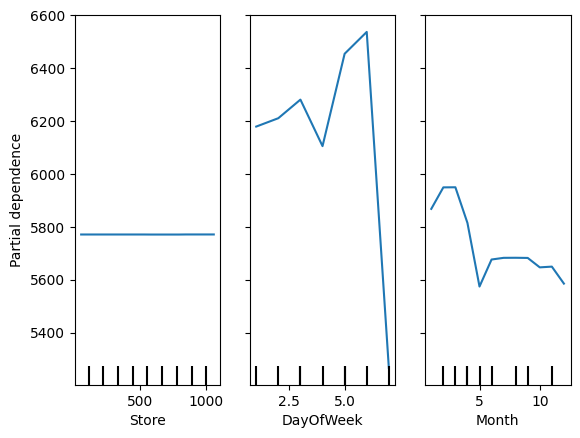

In [63]:
from lightgbm import LGBMRegressor
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Fit the model
lgb_model = LGBMRegressor(random_state=42)
lgb_model.fit(X_train, y_train)

# Get actual feature names after transformation
feature_names = X_train.columns.tolist()  # or preprocessor.get_feature_names_out()
print(feature_names)

# Choose valid features from the above list
features_to_plot = [feature_names[0], feature_names[1], feature_names[2]]

# PDP
PartialDependenceDisplay.from_estimator(
    lgb_model,
    X_train,
    features=features_to_plot,
    grid_resolution=20
)
plt.show()


## 11. Prediction helper & iterative forecasting function

In [64]:
def prepare_history_for_store(store_id, history_df):
    h = history_df[history_df['Store']==store_id].sort_values('Date')
    return h

def predict_store_horizon(store_id, as_of_date, horizon=14, model=None, history_df=None, features=None):
    if model is None or history_df is None or features is None:
        raise ValueError('model, history_df, and features are required')
    future_dates = pd.date_range(start=as_of_date + pd.Timedelta(days=1), periods=horizon)
    preds = []
    hist = prepare_history_for_store(store_id, history_df).copy()
    for d in future_dates:
        row = {'Store': store_id, 'Date': d}
        row_df = prepare_calendar_features(pd.DataFrame([row])).iloc[0].to_dict()
        # add static encodings
        if not store.empty:
            s = store[store['Store']==store_id]
            if not s.empty:
                s = s.iloc[0]
                if 'StoreType' in s.index:
                    row_df['StoreType_enc'] = encoder.transform([[s['StoreType']]])[0][0]
                if 'Assortment' in s.index:
                    row_df['Assortment_enc'] = encoder.transform([[s['Assortment']]])[0][0]
        # lags
        for lag in [1,7,14]:
            lag_date = d - pd.Timedelta(days=lag)
            val = hist[hist['Date']==lag_date]['Sales']
            row_df[f'Sales_lag_{lag}'] = val.values[0] if not val.empty else np.nan
        # fill missing lags
        for col in ['Sales_lag_1','Sales_lag_7','Sales_lag_14']:
            if col in features and (col not in row_df or pd.isna(row_df.get(col))):
                row_df[col] = hist['Sales'].mean() if not hist.empty else 0
        X_row = pd.DataFrame([row_df])[features]
        if model_name == 'lightgbm':
            yhat = gbm.predict(X_row, num_iteration=gbm.best_iteration)[0]
        else:
            yhat = model.predict(X_row)[0]
        preds.append({'Store': store_id, 'Date': d, 'PredictedSales': max(0, yhat)})
        hist = pd.concat([hist, pd.DataFrame({'Store':[store_id],'Date':[d],'Sales':[yhat]})], ignore_index=True)
    return pd.DataFrame(preds)


## 12. Streamlit app script (saved to `salecaster_app.py`)

In [1]:
print('salecaster_app.py created in the working directory')

salecaster_app.py created in the working directory
